# Análisis de Canibalización a través de Reglas de Asociación inversas

El propósito de este notebook es utilizar un modelo de Reglas de asociación para encontrar relaciones inversas entre clientes. Esto para tratar de econtrar conjuntos de clientes que canibalicen las ventas de otros clientes.

Este proyecto fue realizado para la clase de Ciencia de Datos: principios, herramientas y aplicaciones, en el semestre de Ago-Dic 2020.

Equipo 4:
* Rodrigo Esparza
* Ian Pablo Granados
* Alexis Virgen
* Carlos Bueno





In [ ]:
# Importando librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Análisis exploratorio

In [ ]:
#Leer archivos de google drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive'

KeyboardInterrupt: ignored

In [ ]:
#Leer los datos
data = pd.read_csv('Data Science/Data_Proyecto.csv')
data.head()

,det_segment,week,lat2,long2,Sales2,Customer
0,COLAS REGULAR,202031,28.236233,-101.96155,183.9966,4987560947
1,SABORES REGULAR,202031,28.236233,-101.96155,38.3163,4987560947
2,AGUA MINERAL,202032,28.236233,-101.96155,3.8043,4987560947
3,BEBIDAS DE FRUTA,202032,28.236233,-101.96155,19.1268,4987560947
4,BEBIDAS ENERGETICAS,202032,28.236233,-101.96155,0.9996,4987560947


In [ ]:
# Tamaño de datos
data.shape

(355105, 6)

In [ ]:
# Tipo de datos
data.dtypes

det_segment     object
week             int64
lat2           float64
long2          float64
Sales2         float64
Customer         int64
dtype: object

In [ ]:
#Todos los productos que tenemos (18)
datosProducto = data.groupby(['det_segment']).sum().reset_index()
datosProducto.head()

,det_segment,week,lat2,long2,Sales2,Customer
0,AGUA MINERAL,5637609774,786197.363789,-2.845623e+06,280645.084712,140223928104548
1,AGUA PURIFICADA,5164445948,720259.919483,-2.606860e+06,453995.711730,128472830348044
2,AGUA SABORIZADA,1241712456,173163.892058,-6.267801e+05,41374.842833,30837784704132
3,BEBIDAS CON ALCOHOL,808162,112.445160,-4.082667e+02,339.840600,19959598168
4,BEBIDAS DE FRUTA,5024636391,700770.773336,-2.535877e+06,269260.493641,124866581400420


In [ ]:
#Todas las semanas que tenemos (11)
datosSemanas = data.groupby(['week']).sum().reset_index()
datosSemanas.head()

,week,lat2,long2,Sales2,Customer
0,202031,753411.297413,-2.726911e+06,8.941968e+05,134415742815593
1,202032,895768.502517,-3.242340e+06,1.242042e+06,159899464185961
2,202033,942986.939492,-3.413272e+06,1.269434e+06,168351540256863
3,202034,976037.762364,-3.533163e+06,1.322161e+06,174295149915858
4,202035,971242.153008,-3.515841e+06,1.298152e+06,173444835782898


In [ ]:
#Todos los clientes que tenemos (11365)
datosClientes = data.groupby(['Customer']).sum().reset_index()
datosClientes.head()

,Customer,week,lat2,long2,Sales2
0,4987560947,12930309,1807.118912,-6525.539200,2573.7954
1,4987560957,17981214,2512.876908,-9074.404133,9320.0277
2,4987561027,17577156,2458.646709,-8870.947344,4142.1006
3,4987561037,14748638,2059.542868,-7443.505955,3227.0562
4,4987561107,18385285,2572.108357,-9277.416239,5389.7859


In [ ]:
#Sacar todas las ubicaciones (10035)
dataUbicaciones = data.groupby(['lat2','long2']).sum().reset_index()
dataUbicaciones.head()

,lat2,long2,week,Sales2,Customer
0,22.201588,-100.970626,2222397,14.119074,55968252747
1,22.201591,-100.970642,2020365,3.211530,50880235470
2,22.563230,-98.873558,808146,38.793750,20352207388
3,24.658852,-102.786311,1010183,52.836000,25440538135
4,24.664477,-102.765386,2222395,71.392104,55969183787


### K-means para separar los clientes por "colonias"

Antes de poder hacer un modelo de Reglas de Asociación, es encesario separar los datos en grupos más pequeños. Estos grupos servirán tanto para facilitar computacionalmente el proceso de reglas de asociación, sino que también restringirán el estudio de reglas a clientes que se encuentren cerca geográficamente

In [ ]:
!pip install mpld3

In [ ]:
# Importar librerías necesarias
%matplotlib inline
from sklearn.cluster import KMeans
import mpld3
mpld3.enable_notebook()

Antes de hacer la clusterización, eliminaremos de los datos a aquellas ubicaciones que se encuentren muy lejanas. Esto lo hacemos ya que conceptualmente no puede haber canibalización entre sucursales muy lejanas, y para poner visualziar mejor las ubicaciones.

In [ ]:
#Sacamos las colonias que vamos a agrupar
coloniasCluster = dataUbicaciones[['lat2','long2']]

# Quitar ubicaciones muy lejanas, y que por lo tanto no quedaría bien en un cluster
coloniasCluster = coloniasCluster[coloniasCluster['long2'] < -101.2]
coloniasCluster = coloniasCluster[coloniasCluster['long2'] > -102.3]
coloniasCluster = coloniasCluster[coloniasCluster['lat2'] > 27]
coloniasCluster = coloniasCluster[coloniasCluster['lat2'] < 28.6]

data = data[data['long2'] < -101.2]
data = data[data['long2'] > -102.3]
data = data[data['lat2'] > 27]
data = data[data['lat2'] < 28.6]

coloniasCluster

,lat2,long2
5,27.628927,-101.928927
7,27.673164,-101.621137
10,27.757866,-101.854302
11,27.770786,-102.014572
13,27.860700,-102.053607
...,...,...
10028,28.399050,-101.832283
10029,28.453003,-101.814879
10030,28.457567,-101.817833
10031,28.459932,-101.821697


Enseguida graficaremos todas las ubicaciones.

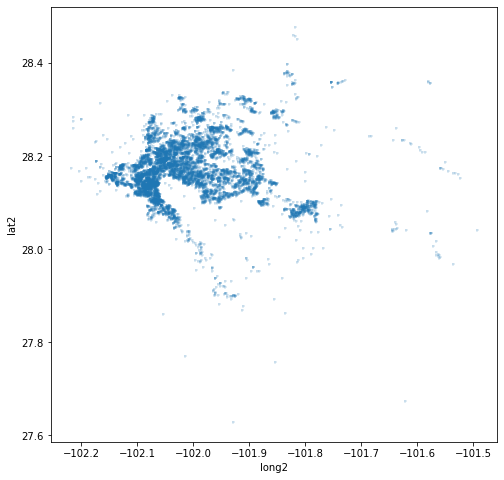

In [ ]:
# Graficar ubicaciones antes de clusterización
plt.figure(figsize=(8, 8))

sns.scatterplot(
    x='long2',
    y='lat2',
    data=coloniasCluster,
    s=9,
    marker='+'
)

plt.show()

Usaremos el algoritmo de K-means para hacer clusters con las ubicaciones. Después de varias pruebas, determinamos que 400 centroides daba clusters de un tamaño adecuado para el algoritmo y tenían una distancia apropiada.

También mostramos los clusters que se forman, para visualizar la segmentación y los tamaños de cluster.

In [ ]:
#Hacemos algoritmo Kmean (Dividimos en 400 colonias)
clustering = KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600, 
       n_clusters=400, n_init=10, random_state=42, tol=0.0001, verbose=0)
labels = clustering.fit_predict(coloniasCluster)

results = coloniasCluster
results['Clusters_Colonia'] = labels

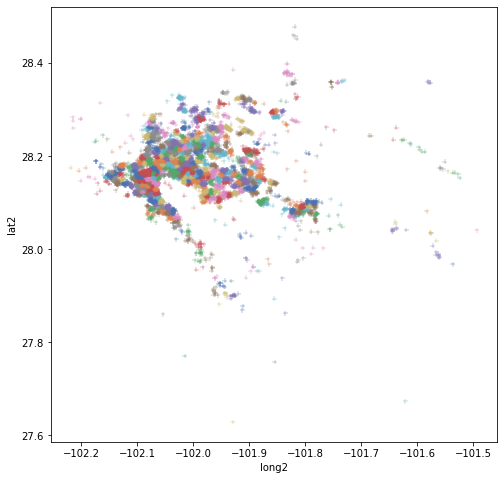

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='long2',
    y='lat2',
    hue="Clusters_Colonia",
    palette="deep",
    data=results,
    s=24,
    legend=False,
    marker='+'
)

plt.show()

In [ ]:
# Promedio de ubicaciones por cluster
results['Clusters_Colonia'].value_counts().mean()

25.0025

In [ ]:
# Número de ubicaciones por cluster
dataLocColonias = results.groupby(['Clusters_Colonia']).agg('count').reset_index()
dataLocColonias.sort_values(by=['lat2'], ascending=True)

,Clusters_Colonia,lat2,long2
358,358,1,1
270,270,1,1
126,126,1,1
221,221,1,1
49,49,1,1
...,...,...,...
371,371,71,71
90,90,73,73
26,26,78,78
11,11,78,78


In [ ]:
# !pip install geopy

In [ ]:
# Calcular distancia máxima promedio en un cluster (entre dos puntos, en km)
from geopy.distance import distance
distances = results.groupby('Clusters_Colonia')\
    .apply(lambda x: distance((x['lat2'].min(), x['long2'].min()), (x['lat2'].max(), x['long2'].max())).km)

print('%s km' % format(distances.mean()))

1.4641266663211367 km


Como pudimos ver en las celdas pasadas, cada cluster tiene un promedio de 25 ubicaciones, y un tamaño promedio de 1.46km de diametro.

In [ ]:
#Agregamos a los datos la colonia de su ubicacion
data = pd.merge(data, results, on=['lat2','long2'])
data.head()

,det_segment,week,lat2,long2,Sales2,Customer,Clusters_Colonia
0,COLAS REGULAR,202031,28.236233,-101.96155,183.9966,4987560947,146
1,SABORES REGULAR,202031,28.236233,-101.96155,38.3163,4987560947,146
2,AGUA MINERAL,202032,28.236233,-101.96155,3.8043,4987560947,146
3,BEBIDAS DE FRUTA,202032,28.236233,-101.96155,19.1268,4987560947,146
4,BEBIDAS ENERGETICAS,202032,28.236233,-101.96155,0.9996,4987560947,146


## Reglas de asociación inversas
Una vez que tenemos los datos separados por colonia, aplicaremos reglas de asosiación a cada producto de cada colonia, con los clientes como nuestros elementos a analizar. Al tener un lift menor a 1, las reglas de asociación serán inversas, en otras palabras, cuando ocurre un antecedente, no ocurre un precedente.

Para la tabla de transacciones, determinamos como 1 los valores de ventas que estén por arriba o igual al promedio de ese cliente en ese producto,  y como 0 los que esten debajo.

Aplicaremos este algoritmo por cada colonia, y cada producto.

In [ ]:
#importar librerias a usar
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#detectar todas las colonias
colonias = data.Clusters_Colonia.unique()
#detectar todos los productos
productos = data.det_segment.unique()
cont = 0
maxCol = 0
exeptions = {"Colonia": [], "Producto": [], "Cantidad":[]}
canibalization = pd.DataFrame()
#Recorrer todas las colonias
for colonia in colonias:
  #Crear Dataframe de esa colonia es especifico
  specificCol = data[data['Clusters_Colonia'] == colonia]
  #Recorrer todos los productos
  for producto in productos:
    #Crear Dataframe con ese producto en especifico
    specificCol_specificProduct = specificCol[specificCol['det_segment'] == producto]
    #Filtrar por average
    meanSales = specificCol_specificProduct['Sales2'].mean()
    specificCol_specificProduct = specificCol_specificProduct[specificCol_specificProduct['Sales2'] > meanSales]
    #Hacer crossTable entre clientes y semana (para tener una tabla de 1 y 0)
    specificCol_specificProduct_CrossTable = pd.crosstab(specificCol_specificProduct['week'], specificCol_specificProduct['Customer'])
    ##########print(specificCol_specificProduct_CrossTable)
    # Utilizar apriori para esta tabla
    if len(specificCol_specificProduct_CrossTable.columns) < 50:
      print("Colonia = ", colonia)
      print("Producto = ", producto)
      print("Contador = ",cont)
      print("Columnas = ",len(specificCol_specificProduct_CrossTable.columns))
      if len(specificCol_specificProduct_CrossTable.columns) > maxCol:
        maxCol = len(specificCol_specificProduct_CrossTable.columns)
      print("NUMERO MAXIMO COLUMNAS", maxCol)
      cont = cont + 1
      specificCol_specificProduct_itemset = apriori(specificCol_specificProduct_CrossTable, min_support = .8, use_colnames=True)
      #Validar que exista algun cliente en la tabla
      if specificCol_specificProduct_itemset.shape[0] > 0:
        rules = association_rules(specificCol_specificProduct_itemset, metric='lift', min_threshold=0)
        rules['Colonia'] = colonia
        rules['Producto'] = producto
        canibalization = [canibalization, rules]
        canibalization = pd.concat(canibalization)
    else:
      # Validar los casos de exepcion 
      exeptions["Colonia"].append(colonia)
      exeptions["Producto"].append(producto)
      exeptions["Cantidad"].append(len(specificCol_specificProduct_CrossTable.columns))


    

### Análisis de reglas

Una vez que pasamos las reglas generadas a un archivo csv, analizaremos los resultados obtenidos. Buscamos reglas con un lift menor a 1, y con suficiente support y confidence.

In [ ]:
rules = pd.read_csv('Data Science/rules.csv')

In [ ]:
rules

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Colonia,Producto
0,0,frozenset({4987562197}),frozenset({4987560957}),1.000000,1.000000,1.000000,1.000000,1.0,0.0,inf,146,COLAS REGULAR
1,1,frozenset({4987560957}),frozenset({4987562197}),1.000000,1.000000,1.000000,1.000000,1.0,0.0,inf,146,COLAS REGULAR
2,2,frozenset({4987560957}),frozenset({4987563207}),1.000000,0.909091,0.909091,0.909091,1.0,0.0,1.0,146,COLAS REGULAR
3,3,frozenset({4987563207}),frozenset({4987560957}),0.909091,1.000000,0.909091,1.000000,1.0,0.0,inf,146,COLAS REGULAR
4,4,frozenset({4987560957}),frozenset({4987563927}),1.000000,1.000000,1.000000,1.000000,1.0,0.0,inf,146,COLAS REGULAR
...,...,...,...,...,...,...,...,...,...,...,...,...
8539567,9,frozenset({5090901317}),"frozenset({5089846717, 5090909247})",1.000000,0.818182,0.818182,0.818182,1.0,0.0,1.0,168,SABORES REGULAR
8539568,10,frozenset({5089846717}),"frozenset({5090901317, 5090909247})",1.000000,0.818182,0.818182,0.818182,1.0,0.0,1.0,168,SABORES REGULAR
8539569,11,frozenset({5090909247}),"frozenset({5090901317, 5089846717})",0.818182,1.000000,0.818182,1.000000,1.0,0.0,inf,168,SABORES REGULAR
8539570,0,frozenset({5090926197}),frozenset({5090590597}),1.000000,1.000000,1.000000,1.000000,1.0,0.0,inf,169,ISOTÃ“NICOS REGULAR


In [ ]:
canibalizacion = rules[rules["lift"] < .99]
canibalizacion

,Unnamed: 0,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Colonia,Producto
260168,0,frozenset({4987701057}),frozenset({5088889947}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,268,AGUA MINERAL
260169,1,frozenset({5088889947}),frozenset({4987701057}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,268,AGUA MINERAL
427702,0,frozenset({4987886457}),frozenset({4987691227}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,320,SABORES REGULAR
427703,1,frozenset({4987691227}),frozenset({4987886457}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,320,SABORES REGULAR
8521994,0,frozenset({4987881547}),frozenset({4987886287}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,272,COLAS LIGHT
8521995,1,frozenset({4987886287}),frozenset({4987881547}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,272,COLAS LIGHT
8524114,0,frozenset({5089399217}),frozenset({4987889637}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,337,BEBIDAS DE FRUTA
8524115,1,frozenset({4987889637}),frozenset({5089399217}),0.9,0.9,0.8,0.888889,0.987654,-0.01,0.9,337,BEBIDAS DE FRUTA


Cómo podemos observar, las reglas generadas tienen lifts muy cercanos a 1. Esto significa que las reglas realmente reflejan relaciones aleatorias entre clientes, y no reglas que muestren canibalización.

Además, vemos pares de reglas que se contradicen (A->B y B->A). Aún así, graficaremos estos resultados para estudiar si hay canibalización entre ellos.

In [ ]:
clientesSet1 = data[((data["Customer"] == 4987701057) | (data["Customer"] == 5088889947)) & (data["det_segment"] == "AGUA MINERAL")]
clientesSet2 = data[((data["Customer"] == 4987886457) | (data["Customer"] == 4987691227)) & (data["det_segment"] == "SABORES REGULAR")]
clientesSet3 = data[((data["Customer"] == 4987886287) | (data["Customer"] == 4987881547)) & (data["det_segment"] == "COLAS LIGHT")]
clientesSet4 = data[((data["Customer"] == 4987889637) | (data["Customer"] == 5089399217)) & (data["det_segment"] == "BEBIDAS DE FRUTA")]

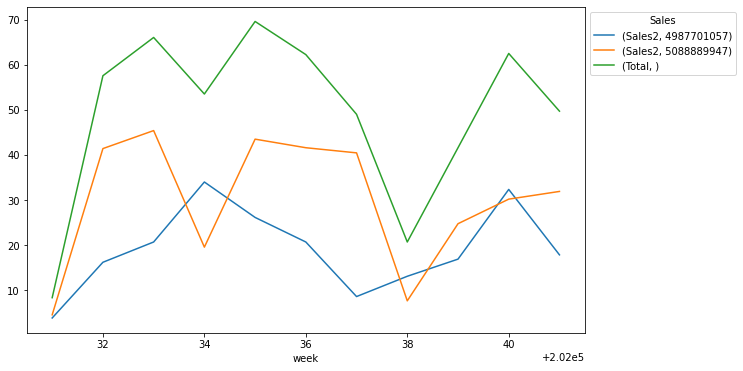

In [ ]:
clientesSet1 = pd.pivot_table(clientesSet1, index=['week'], columns=["Customer"], values=["Sales2"])
clientesSet1["Total"] = clientesSet1["Sales2"].sum(axis=1)
clientesSet1.plot(figsize=(10,6)).legend(title='Sales', bbox_to_anchor=(1, 1))

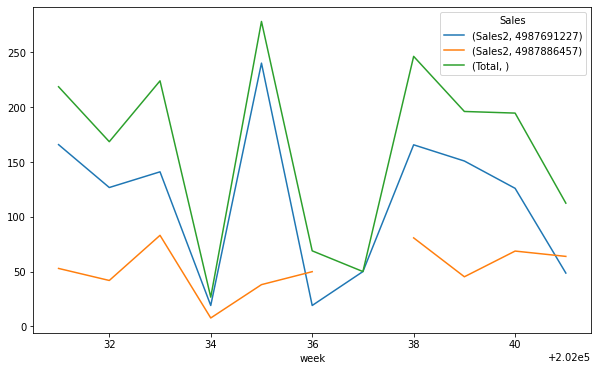

In [ ]:
clientesSet2 = pd.pivot_table(clientesSet2, index=['week'], columns=["Customer"], values=["Sales2"])
clientesSet2["Total"] = clientesSet2["Sales2"].sum(axis=1)
clientesSet2.plot(figsize=(10,6)).legend(title='Sales', bbox_to_anchor=(1, 1))

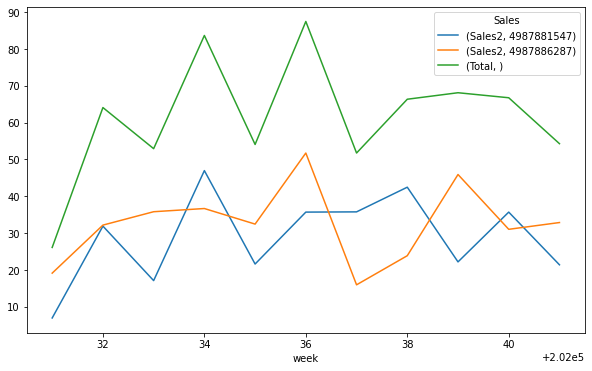

In [ ]:
clientesSet3 = pd.pivot_table(clientesSet3, index=['week'], columns=["Customer"], values=["Sales2"])
clientesSet3["Total"] = clientesSet3["Sales2"].sum(axis=1)
clientesSet3.plot(figsize=(10,6)).legend(title='Sales', bbox_to_anchor=(1, 1))

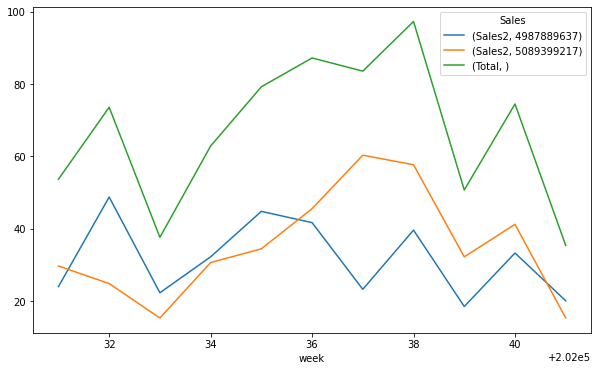

In [ ]:
clientesSet4 = pd.pivot_table(clientesSet4, index=['week'], columns=["Customer"], values=["Sales2"])
clientesSet4["Total"] = clientesSet4["Sales2"].sum(axis=1)
clientesSet4.plot(figsize=(10,6)).legend(title='Sales', bbox_to_anchor=(1, 1))

In [ ]:
clientesSet2 = pd.pivot_table(clientesSet2, index=['Customer'], columns=["week"], values=["Sales2"])
clientesSet2

Sales2                      ...                             
week          202031    202032    202033  ...    202039    202040   202041
Customer                                  ...                             
4987691227  165.8613  126.7002  141.0294  ...  150.9006  125.9616  48.6090
4987886457   52.8357   41.8461   83.0580  ...   45.2280   68.6865  63.8265

[2 rows x 11 columns]

In [ ]:
clientesSet3 = pd.pivot_table(clientesSet3, index=['Customer'], columns=["week"], values=["Sales2"])
clientesSet3

Sales2                    ...                           
week         202031   202032   202033  ...   202039   202040   202041
Customer                               ...                           
4987881547   6.9744  31.9131  17.1189  ...  22.2018  35.7174  21.4089
4987886287  19.1475  32.1876  35.8221  ...  45.9249  31.0461  32.8848

[2 rows x 11 columns]

In [ ]:
clientesSet4 = pd.pivot_table(clientesSet4, index=['Customer'], columns=["week"], values=["Sales2"])
clientesSet4

Sales2                    ...                           
week         202031   202032   202033  ...   202039   202040   202041
Customer                               ...                           
4987889637  23.9877  48.7680  22.2969  ...  18.4926  33.2868  20.0778
5089399217  29.6940  24.8331  15.3225  ...  32.2299  41.2122  15.3225

[2 rows x 11 columns]

Cómo pudimos observar a través de las gráficas aún las mejores reglas no muestran a simple vista canibalización entre clientes. Por lo tanto, se puede concluir que el modelo no fue exitoso en encontrar canibalización.

### Experimentación posterior

Para poder analizar más casos, determinamos hacer pruebas con un solo cluster. En estas pruebas variamos en el support mínimo que se da al algorimo de Reglas de Asociación.

In [ ]:
#Seleccionamos una colonia a analizar
colonia303 = data[data['Clusters_Colonia'] == 303]
colonia303

,det_segment,week,lat2,long2,Sales2,Customer,Clusters_Colonia
162002,COLAS LIGHT,202031,28.162816,-102.093262,3.1701,4987844617,303
162003,COLAS REGULAR,202031,28.162816,-102.093262,72.9132,4987844617,303
162004,JUGOS Y NÃ‰CTARES,202031,28.162816,-102.093262,1.5852,4987844617,303
162005,SABORES REGULAR,202031,28.162816,-102.093262,15.3225,4987844617,303
162006,AGUA PURIFICADA,202032,28.162816,-102.093262,4.7553,4987844617,303
...,...,...,...,...,...,...,...
349043,AGUA PURIFICADA,202040,28.167438,-102.089979,3.1701,5091558717,303
349044,BEBIDAS DE FRUTA,202040,28.167438,-102.089979,0.7926,5091558717,303
349045,COLAS LIGHT,202040,28.167438,-102.089979,7.6719,5091558717,303
349046,COLAS REGULAR,202040,28.167438,-102.089979,24.8538,5091558717,303


In [ ]:
#Vemos los productos que se venden en esa colonia
colonia303Productos = colonia303.groupby(['det_segment']).sum().reset_index()
colonia303Productos

,det_segment,week,lat2,long2,Sales2,Customer,Clusters_Colonia
0,AGUA MINERAL,20809712,2901.117213,-10515.208709,857.420632,516803485071,31209
1,AGUA PURIFICADA,18789345,2619.365587,-9494.338634,1677.357000,466612027191,28179
2,AGUA SABORIZADA,9091620,1267.518526,-4594.082328,232.049700,225378414075,13635
3,BEBIDAS DE FRUTA,20607688,2872.965833,-10413.148714,1290.658200,511822713214,30906
4,BEBIDAS DE SOYA,4242747,591.465376,-2143.847225,45.285000,105848507777,6363
5,BEBIDAS ENERGETICAS,5252951,732.325437,-2654.373438,31.416600,130503690102,7878
6,COLAS LIGHT,58388445,8139.618721,-29503.838762,6944.442009,1459726356683,87567
7,COLAS REGULAR,71924833,10026.711557,-36343.754876,28187.430204,1799059926912,107868
8,ISOTÃ“NICOS REGULAR,15556766,2168.808108,-7860.953220,524.327100,386419004599,23331
9,JUGOS Y NÃ‰CTARES,15758837,2196.967890,-7962.985741,342.585600,390794169976,23634


In [ ]:
#Seleccionamos un producto a analizar (Se tendria que hacer con todos los productos)
colonia303_AGUA_MINERAL = colonia303[colonia303['det_segment'] == 'AGUA MINERAL']
colonia303_AGUA_MINERAL

,det_segment,week,lat2,long2,Sales2,Customer,Clusters_Colonia
162022,AGUA MINERAL,202035,28.162816,-102.093262,3.8043,4987844617,303
162029,AGUA MINERAL,202037,28.162816,-102.093262,4.7553,4987844617,303
166510,AGUA MINERAL,202032,28.161833,-102.086350,17.1192,4987862417,303
166520,AGUA MINERAL,202033,28.161833,-102.086350,15.2172,4987862417,303
166529,AGUA MINERAL,202034,28.161833,-102.086350,15.9144,4987862417,303
...,...,...,...,...,...,...,...
324316,AGUA MINERAL,202036,28.170100,-102.088290,3.8043,5090732967,303
324324,AGUA MINERAL,202037,28.170100,-102.088290,8.5596,5090732967,303
324333,AGUA MINERAL,202038,28.170100,-102.088290,3.8043,5090732967,303
324345,AGUA MINERAL,202040,28.170100,-102.088290,12.3639,5090732967,303


In [ ]:
pruebaCustomer = colonia303_AGUA_MINERAL.groupby(['Customer']).sum().reset_index()
pruebaCustomer

,Customer,week,lat2,long2,Sales2,Clusters_Colonia
0,4987844617,404072,56.325632,-204.186524,8.559600,606
1,4987862417,1616292,225.294664,-816.690800,129.027600,2424
2,4987866687,2020364,281.650640,-1020.860740,89.272200,3030
3,4987875247,2020357,281.672110,-1020.931510,60.804300,3030
4,4987876737,1818324,253.521657,-918.794718,54.146700,2727
5,4987876857,1616288,225.335296,-816.736072,65.813400,2424
6,4987877617,2020365,281.642670,-1020.937000,147.097800,3030
7,4987878267,1616288,225.348776,-816.707224,67.461600,2424
8,4987879377,808140,112.668592,-408.338332,18.006000,1212
9,4987886567,808144,112.647304,-408.344652,25.614600,1212


In [ ]:
meanSales = colonia303_AGUA_MINERAL['Sales2'].mean()
colonia303_AGUA_MINERAL = colonia303_AGUA_MINERAL[colonia303_AGUA_MINERAL['Sales2'] > meanSales]

In [ ]:
#Creamos tabla del producto por semana entre los clientes de agua mineral
colonia303_Cant_AGUA_MINERAL = pd.crosstab(colonia303_AGUA_MINERAL['week'], colonia303_AGUA_MINERAL['Customer'])
colonia303_Cant_AGUA_MINERAL

Customer,4987862417,4987866687,4987875247,4987876737,4987876857,4987877617,4987878267,4987886567,5089072297,5090732967
week,,,,,,,,,,
202032,1,0,0,0,0,1,0,0,0,0
202033,1,1,0,1,0,1,1,0,0,1
202034,1,1,1,0,1,1,0,1,1,0
202035,0,1,0,0,0,1,1,0,0,1
202036,1,0,0,0,1,1,0,0,0,0
202037,0,0,0,0,0,1,0,0,0,1
202038,0,0,0,1,1,0,0,0,0,0
202039,1,0,0,0,1,1,1,0,0,0
202040,0,1,1,0,0,0,0,0,0,1


In [ ]:
colonia303_Cant_AGUA_MINERAL.info

<bound method DataFrame.info of Customer  4987862417  4987866687  ...  5089072297  5090732967
week                              ...                        
202032             1           0  ...           0           0
202033             1           1  ...           0           1
202034             1           1  ...           1           0
202035             0           1  ...           0           1
202036             1           0  ...           0           0
202037             0           0  ...           0           1
202038             0           0  ...           0           0
202039             1           0  ...           0           0
202040             0           1  ...           0           1
202041             1           0  ...           0           1

[10 rows x 10 columns]>

In [ ]:
colonia303_Cant_AGUA_MINERAL.dtypes

Customer
4987862417    int64
4987866687    int64
4987875247    int64
4987876737    int64
4987876857    int64
4987877617    int64
4987878267    int64
4987886567    int64
5089072297    int64
5090732967    int64
dtype: object

In [ ]:
from mlxtend.frequent_patterns import apriori

#Vemos la relacion que los clientes mismos tienen entre este producto
colonia303_AGUA_MINERAL_itemset = apriori(colonia303_Cant_AGUA_MINERAL, min_support = .1, use_colnames=True)
colonia303_AGUA_MINERAL_itemset.sort_values(by='support', ascending=False)

,support,itemsets
5,0.8,(4987877617)
0,0.6,(4987862417)
14,0.6,"(4987862417, 4987877617)"
9,0.5,(5090732967)
1,0.4,(4987866687)
...,...,...
78,0.1,"(5090732967, 4987876737, 4987866687)"
79,0.1,"(4987876857, 4987877617, 4987866687)"
80,0.1,"(4987876857, 4987886567, 4987866687)"
81,0.1,"(5089072297, 4987876857, 4987866687)"


In [ ]:
from mlxtend.frequent_patterns import association_rules

#Se crean las reglas de dependencia de clientes por producto
canibalization = association_rules(colonia303_AGUA_MINERAL_itemset, metric='lift', min_threshold=0)
canibalization = canibalization[canibalization['lift'] < 1]
canibalization.sort_values(by='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
115,"(4987866687, 5090732967)",(4987862417),0.3,0.6,0.1,0.333333,0.555556,-0.08,0.600000
118,(4987862417),"(4987866687, 5090732967)",0.6,0.3,0.1,0.166667,0.555556,-0.08,0.840000
602,"(4987866687, 5090732967)","(4987862417, 4987877617)",0.3,0.6,0.1,0.333333,0.555556,-0.08,0.600000
603,"(4987862417, 4987877617)","(4987866687, 5090732967)",0.6,0.3,0.1,0.166667,0.555556,-0.08,0.840000
232,(4987877617),"(4987866687, 4987875247)",0.8,0.2,0.1,0.125000,0.625000,-0.06,0.914286
...,...,...,...,...,...,...,...,...,...
1514,(4987862417),"(4987877617, 4987878267, 4987866687, 5090732967)",0.6,0.2,0.1,0.166667,0.833333,-0.02,0.960000
53,(4987877617),(4987876857),0.8,0.4,0.3,0.375000,0.937500,-0.02,0.960000
52,(4987876857),(4987877617),0.4,0.8,0.3,0.750000,0.937500,-0.02,0.800000
25,(4987866687),(4987877617),0.4,0.8,0.3,0.750000,0.937500,-0.02,0.800000


In [ ]:
#Observamos en donde se presenta canivalizacion entre los clientes (Esto es de un producto de una colonia)
canibalization[canibalization["lift"] < .56]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
115,"(4987866687, 5090732967)",(4987862417),0.3,0.6,0.1,0.333333,0.555556,-0.08,0.60
118,(4987862417),"(4987866687, 5090732967)",0.6,0.3,0.1,0.166667,0.555556,-0.08,0.84
602,"(4987866687, 5090732967)","(4987862417, 4987877617)",0.3,0.6,0.1,0.333333,0.555556,-0.08,0.60
603,"(4987862417, 4987877617)","(4987866687, 5090732967)",0.6,0.3,0.1,0.166667,0.555556,-0.08,0.84


En este caso obtenemos relaciones con mejor lift, sin embargo, el support y confidence de estas reglas es demasiado bajo, por lo tanto no serían reglas confiables.

Graficaremos un caso, para confirmar que no haya canibalización.

In [ ]:
clientesSetPrueba = data[((data["Customer"] == 4987866687) | (data["Customer"] == 5090732967) | (data["Customer"] == 4987862417) ) & (data["det_segment"] == "AGUA MINERAL")]

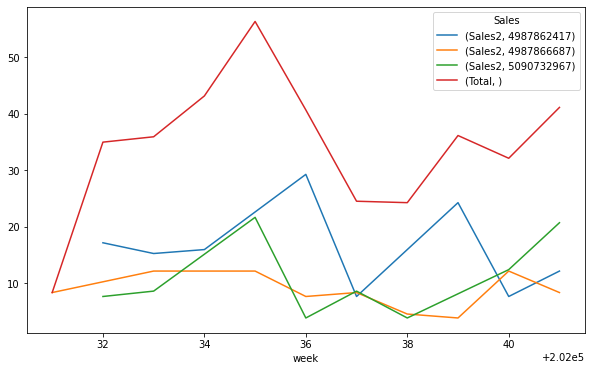

In [ ]:
clientesSetPrueba = pd.pivot_table(clientesSetPrueba, index=['week'], columns=["Customer"], values=["Sales2"])
clientesSetPrueba = clientesSetPrueba.interpolate(method='linear', limit_direction='forward', axis=0)
clientesSetPrueba["Total"] = clientesSetPrueba["Sales2"].sum(axis=1)
clientesSetPrueba.plot(figsize=(10,6)).legend(title='Sales', bbox_to_anchor=(1, 1))

## Conclusiones

A través de esta experimentación podemos afirmar que el modelo de Reglas de Asociación no es un algoritmo que pueda detectar canibalización de forma exitosa. Los resultados obtenidos presentan estadísticas que muestran que son reglas muy aleatorias, o con poca confianza. Además, al graficar las mejor reglas, no se puede apreciar el efecto de la canibalización en las ventas de los clientes.

Al analizar el modelo, observamos que una de las principales razones para que no sea exitoso es que el modelo hace binario un problema continuo. Por lo tanto, el reducir los datos a una forma binaria, no permite la correcta detección de canibalización. Este problema requiere de un análisis más apegado a modelos basados en regresiones y series de tiempo.

